This post is a followup to [a recent one](https://greglandrum.github.io/rdkit-blog/posts/2025-03-21-similarity-hitset-overlap-1.html) exploring the amount of overlap in the hit sets returned by doing similarity searches with different fingerprint types.

At the end of the intro to that post I said:

> One thing that is worth keeping in mind is that these results almost certainly consider similarity values which are down close to and probably in the region of similarities observed between [random compounds](https://greglandrum.github.io/rdkit-blog/posts/2021-05-18-fingerprint-thresholds1.html). It may be worth refining the analysis in order to only consider similarities which are more significant, but that's for a possible future post.

This is that "possible future post". Here I filter the hit sets to only include similarity values greater than or equal to the 99% threshold for each fingerprint in the [post on random similarities](https://greglandrum.github.io/rdkit-blog/posts/2021-05-18-fingerprint-thresholds1.html).

Other than skipping the initial examination of searches done with a single compounds, the rest of the analysis is the same as in earlier post. The results are not qualitatively different, but I think this is a more sensible approach overall.

In [1]:
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs
import numpy as np

from matplotlib import pyplot as plt
plt.style.use('tableau-colorblind10')

%matplotlib inline
%load_ext sql

import rdkit
print(rdkit.__version__)

2025.03.1


In [2]:
import gzip
with gzip.open('../data/Pubchem_AID373_compounds.sdf.gz','rb') as inf:
    with Chem.ForwardSDMolSupplier(inf) as suppl:
        dbmols = [x for x in suppl if x is not None]
len(dbmols)
    

59788

Define the fingerprints and similarity thresholds we will use:

In [3]:
# tuple order: (fp name, generator, count_thresh, bit_thresh)
runs = [
    ('mfp2',rdFingerprintGenerator.GetMorganGenerator(radius=2), 0.30, 0.23),
    ('ffp2',rdFingerprintGenerator.GetMorganGenerator(radius=2,
                                                  atomInvariantsGenerator=rdFingerprintGenerator.GetMorganAtomInvGen()),
        0.32, 0.24),
    ('mfp3',rdFingerprintGenerator.GetMorganGenerator(radius=3), 0.23, 0.17),
    ('ffp3',rdFingerprintGenerator.GetMorganGenerator(radius=3,
                                                  atomInvariantsGenerator=rdFingerprintGenerator.GetMorganAtomInvGen()),
        0.25, 0.18),
    ('mfp1',rdFingerprintGenerator.GetMorganGenerator(radius=1), 0.42, 0.36),
    ('ffp1',rdFingerprintGenerator.GetMorganGenerator(radius=1,
                                                  atomInvariantsGenerator=rdFingerprintGenerator.GetMorganAtomInvGen()),
        0.46, 0.40),
    ('tt',rdFingerprintGenerator.GetTopologicalTorsionGenerator(), 0.26, 0.28),
    ('ap',rdFingerprintGenerator.GetAtomPairGenerator(), 0.32, 0.42),
    ('rdk5',rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5), 0.33, 0.37),
    ('rdk7',rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=7), 0.20, 0.51),
]

In [4]:
from rdkit.Chem.Pharm2D import Gobbi_Pharm2D,Generate
def Gobbi2D_bits(mol,fpLen=2048):
    res = DataStructs.ExplicitBitVect(fpLen)
    for bit in Generate.Gen2DFingerprint(mol,Gobbi_Pharm2D.factory).GetOnBits():
        # the bits are not hashed, so we need to do so before we fold them:
        res.SetBit(hash((bit,))%fpLen)
    return res

In [5]:
from rdkit.Chem import rdMolDescriptors
from rdkit.Avalon import pyAvalonTools

func_runs = [
    ('gobbi2d',Gobbi2D_bits, 0.37),
    ('avalon',pyAvalonTools.GetAvalonFP, 0.59),
    ('avalon-c',pyAvalonTools.GetAvalonCountFP, 0.50),
    ('pattern',Chem.PatternFingerprint, 0.75),
]

In order to get some decent statistics, we will do similarity searches with 500 random molecules.

Running this cell takes a while.

In [6]:
import random
random.seed(0xbad5eed)
order = list(range(len(dbmols)))
random.shuffle(order)

nToDo = 500
order = order[:500]

accum = {}
for nm,fpg,cthresh,bthresh in runs:
    print(nm)
    fps = list(fpg.GetFingerprints(dbmols,numThreads=8))
    taccum = []
    for i in order:
        qry = fps[i]
        sims = [(sim,j) for j,sim in enumerate(DataStructs.BulkTanimotoSimilarity(qry,fps)) if sim>=bthresh and j!=i]
        sims = sorted(sims,reverse=True)[:1000]
        taccum.append(sims)
    accum[f'{nm}-b'] = taccum

    fps = list(fpg.GetCountFingerprints(dbmols,numThreads=8))
    taccum = []
    for i in order:
        qry = fps[i]
        sims = [(sim,j) for j,sim in enumerate(DataStructs.BulkTanimotoSimilarity(qry,fps)) if sim>=cthresh and j!=i]
        sims = sorted(sims,reverse=True)[:1000]
        taccum.append(sims)
    accum[f'{nm}-c'] = taccum

for nm,func,thresh in func_runs:
    print(nm)
    fps = [func(m) for m in dbmols]
    taccum = []
    for i in order:
        qry = fps[i]
        sims = [(sim,j) for j,sim in enumerate(DataStructs.BulkTanimotoSimilarity(qry,fps)) if sim>=thresh and j!=i]
        sims = sorted(sims,reverse=True)[:1000]
        taccum.append(sims)
    accum[nm] = taccum

mfp2
ffp2
mfp3
ffp3
mfp1
ffp1
tt
ap
rdk5
rdk7
gobbi2d
avalon
avalon-c
pattern


In [7]:
import pickle
import gzip
with gzip.open('./results/sim_overlaps_thresh.pkl.gz','wb+') as outf:
    pickle.dump(accum,outf)

Accumulate the overlaps:

In [8]:
from collections import defaultdict

nms = list(accum.keys())

ovls = defaultdict(dict)
topNs = [10,100,1000]
for i,nmi in enumerate(nms):
    nruns = len(accum[nmi])
    for j in range(i):
        nmj = nms[j]
        for topN in topNs:
            ovls[nmi,nmj][topN] = []
        for run in range(nruns):
            topi = [x for s,x in accum[nmi][run]]
            topj = [x for s,x in accum[nmj][run]]
            for topN in topNs:
                ovls[nmi,nmj][topN].append(len(set(topi[:topN]).intersection(topj[:topN])))
ovls = dict(ovls)

Find the most similar fingerprint types for each of the fingerprints, this time using the mean overlap across the 500 hit sets:

In [9]:
snms = sorted(nms)

for i in range(len(snms)):
    print('-'*70)
    print(snms[i])
    for cnt in (10,100,1000):
        row = []
        for j in range(len(snms)):
            if i==j:
                continue
            nmi = snms[i]
            nmj = snms[j]
            if (nmi,nmj) not in ovls:
                nmi,nmj = nmj,nmi
            row.append((np.mean(ovls[nmi,nmj][cnt]),j))
        row = sorted(row,reverse=True)
        nbrs = []
        for j in range(3):
            nbrs.append(f'{snms[row[j][1]]:8s}({row[j][0]:5.1f})')
        print(f'\t{cnt: 5d}',f'{nbrs[0]:17s}',f'{nbrs[1]:17s}',f'{nbrs[2]:16s}',)


----------------------------------------------------------------------
ap-b
	   10 ap-c    (  7.8)   ffp1-c  (  4.9)   mfp1-c  (  4.8) 
	  100 ap-c    ( 61.4)   ffp1-c  ( 34.6)   mfp1-c  ( 34.0) 
	 1000 ap-c    (329.6)   ffp1-c  (189.2)   mfp1-c  (182.2) 
----------------------------------------------------------------------
ap-c
	   10 ap-b    (  7.8)   ffp2-c  (  5.1)   ffp1-c  (  5.1) 
	  100 ap-b    ( 61.4)   ffp1-c  ( 40.2)   mfp1-c  ( 39.0) 
	 1000 ap-b    (329.6)   ffp1-c  (264.2)   mfp1-c  (252.7) 
----------------------------------------------------------------------
avalon
	   10 avalon-c(  5.3)   rdk5-b  (  5.1)   rdk7-b  (  5.1) 
	  100 rdk5-b  ( 42.7)   avalon-c( 40.3)   rdk7-c  ( 40.1) 
	 1000 rdk7-c  (207.2)   avalon-c(195.1)   rdk5-b  (175.3) 
----------------------------------------------------------------------
avalon-c
	   10 avalon  (  5.3)   rdk5-c  (  5.3)   rdk7-c  (  5.1) 
	  100 rdk5-c  ( 42.5)   avalon  ( 40.3)   rdk7-c  ( 40.2) 
	 1000 rdk7-c  (235.7)   rdk5-

Look at histograms of the overlap sizes for a few different fingerprint pairs

In [10]:
def compare(prs,ovls=ovls):
    prs = list(prs)
    for i,pr in enumerate(prs):
        if pr not in ovls:
            pr = pr[1],pr[0]
        prs[i] = pr

    plt.figure(figsize=(12,5))
    for i,n in enumerate((100,1000)):
        plt.subplot(1,2,i+1)
        plt.hist([ovls[pr][n] for pr in prs],label=prs,bins=20);
        plt.xlim(0,n)
        plt.xlabel(f'n={n} overlap')
        #plt.title(pr)
        plt.legend()
    plt.tight_layout()

Start with [FeatureMorgan and Morgan](https://www.rdkit.org/docs/RDKit_Book.html#morgan-and-feature-morgan-fingerprints), where there is a reasonably large amount of overlap:

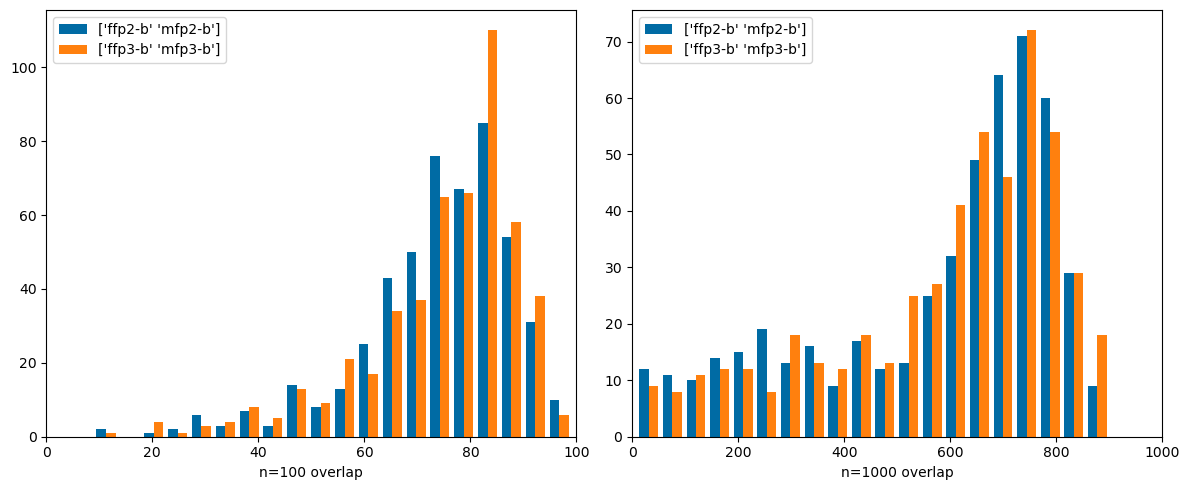

In [11]:
compare((('ffp2-b','mfp2-b'),('ffp3-b','mfp3-b')))

Now compare count-based and bit-based Morgan fingerprints. I expected the overlaps here to be higher:

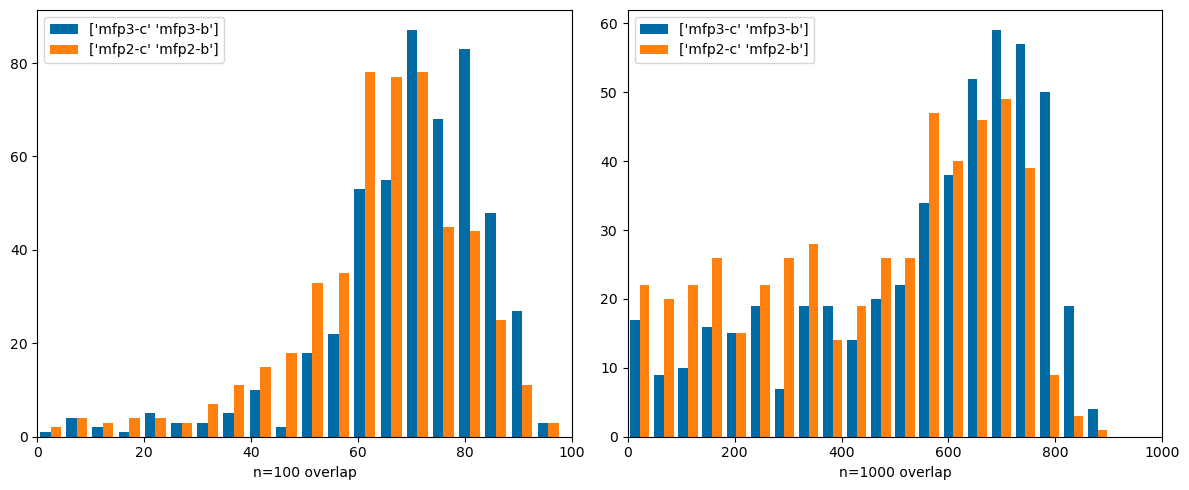

In [12]:
compare((('mfp3-c','mfp3-b'),('mfp2-c','mfp2-b'),))

Comparing very different types of fingerprints: count-based Morgan3 and both [Topological Torsions and Atom Pairs](https://www.rdkit.org/docs/RDKit_Book.html#atom-pair-and-topological-torsion-fingerprints) (these both use [count simulation](https://greglandrum.github.io/rdkit-blog/posts/2021-07-06-simulating-counts.html). Here there are significant differences. These are fingerprints that it would be interesting to use together.

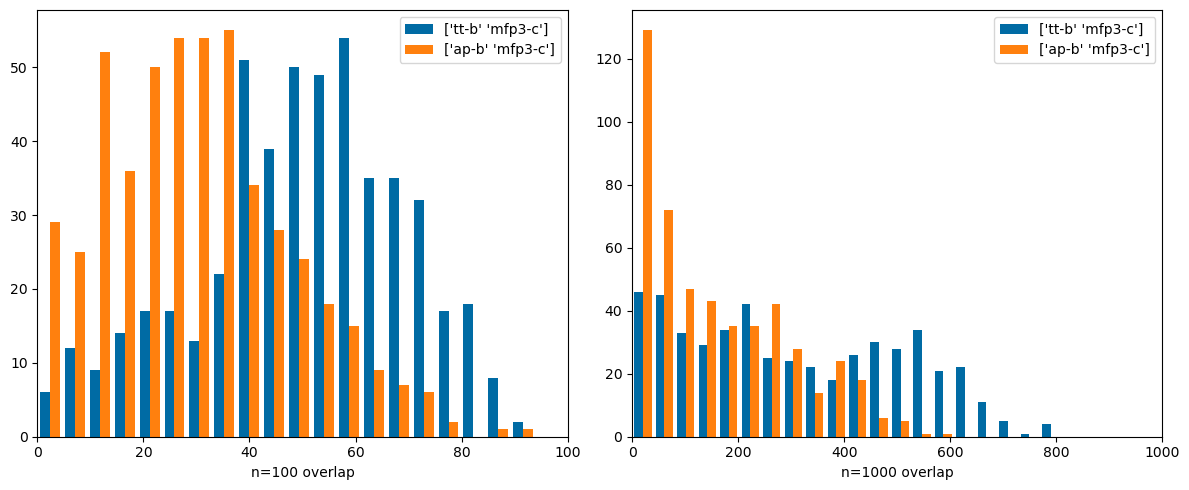

In [13]:
compare((('tt-b','mfp3-c'),('ap-b','mfp3-c')))

Same thing with bit-baseed Morgan3 and [RDK5](https://www.rdkit.org/docs/RDKit_Book.html#rdkit-fingerprints). Again, These are nicely complementary fingerprints:

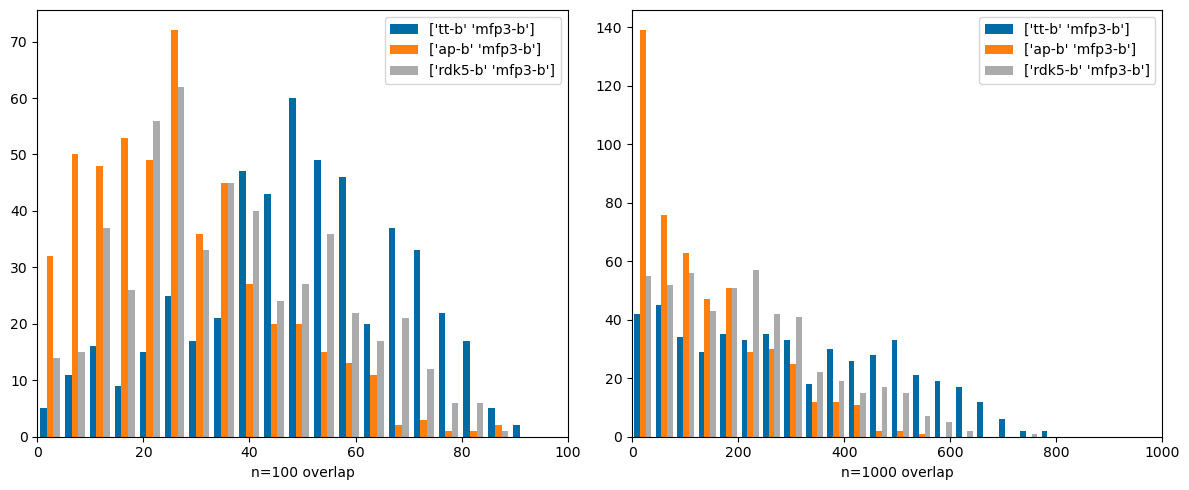

In [14]:
compare((('tt-b','mfp3-b'),('ap-b','mfp3-b'),('rdk5-b','mfp3-b')))

Finally compare Morgan3 with the [pattern fingerprint](https://www.rdkit.org/docs/RDKit_Book.html#pattern-fingerprints) (normally used for substructure screening, not similarity search), Gobbi2D (a 2D pharmacophore FP) and the Avalon FP. These are also nicely different from each other:

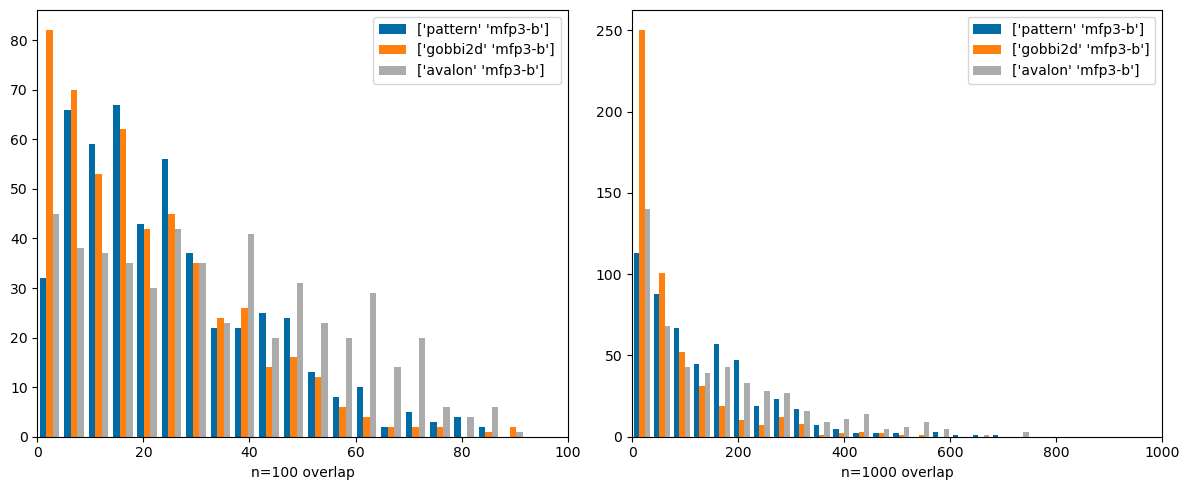

In [15]:
compare((('pattern','mfp3-b'),('gobbi2d','mfp3-b'),('avalon','mfp3-b')))